# WGAN-GP

Critic Loss:

$$
L=\underset{\tilde{\boldsymbol{x}} \sim \mathbb{P}_{g}}{\mathbb{E}}[D(\tilde{\boldsymbol{x}})]-\underset{\boldsymbol{x} \sim \mathbb{P}_{r}}{\mathbb{E}}[D(\boldsymbol{x})]+\lambda \underset{\hat{\boldsymbol{x}} \sim \mathbb{P}_{\hat{\boldsymbol{x}}}}{\mathbb{E}}\left[\left(\left\|\nabla_{\hat{\boldsymbol{x}}} D(\hat{\boldsymbol{x}})\right\|_{2}-1\right)^{2}\right]
$$

Generator Loss

$$
L=- \underset{\tilde{\boldsymbol{x}} \sim \mathbb{P}_{g}}{\mathbb{E}}[D(\tilde{\boldsymbol{x}})]
$$

   
## References

- [Improved Training of Wasserstein GANs](https://arxiv.org/abs/1704.00028)
- [Wasserstein GAN](https://arxiv.org/abs/1701.07875)
- https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
random.seed(manualSeed)
torch.manual_seed(manualSeed)
print("Random Seed: ", manualSeed)

Random Seed:  999


In [2]:
# Root directory for dataset
dataroot = "datasets"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 10

# Size of feature maps in generator
ngf = 20

# Size of feature maps in critic
ndf = 20

# Number of training epochs/iterations
num_epochs = 5
critic_iterations = 5

# Learning rate for optimizers
lr = 0.0001

# Beta1 hyperparam for Adam optimizers
beta1 = 0
beta2 = 0.9

lambda_gradient_penalty = 10

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 2

In [3]:
dataset = datasets.MNIST(root=dataroot, download=True, transform=transforms.ToTensor()
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=workers
)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

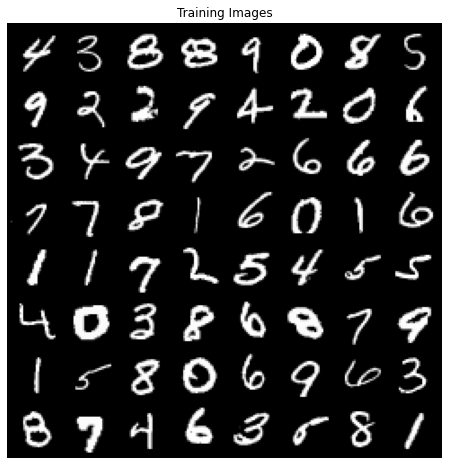

In [4]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 7 x 7

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 14 x 14

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 28 x 28
        )

    def forward(self, input):
        return self.main(input)

In [6]:
# Create the generator
generator = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    generator = nn.DataParallel(generator, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
generator.apply(weights_init)

# Print the model
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(10, 80, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(80, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(40, 20, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(20, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [7]:
class Critic(nn.Module):
    def __init__(self, ngpu):
        super(Critic, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf * 2, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf * 4, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Create the Critic
critic = Critic(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    critic = nn.DataParallel(critic, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
critic.apply(weights_init)

# Print the model
print(critic)

Critic(
  (main): Sequential(
    (0): Conv2d(1, 20, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(20, 40, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): InstanceNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): InstanceNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(80, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


In [9]:
def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [10]:
# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerC = optim.Adam(critic.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

In [11]:
# Training Loop

# Lists to keep track of progress
img_list = []
losses_critic = []
losses_generator = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        real = data[0].to(device)  # we don't use label
        batch_size = real.size(0)
        
        ## Train critic

        for _ in range(critic_iterations):
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake = generator(noise)

            output_real = critic(real).view(-1)
            output_fake = critic(fake).view(-1)
            
            gp = gradient_penalty(critic, real, fake, device=device)

            loss_critic = output_fake.mean() - output_real.mean() + lambda_gradient_penalty * gp

            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            optimizerC.step()

        ## Train generator

        output_fake = critic(fake).view(-1)
        loss_generator = -output_fake.mean()

        generator.zero_grad()
        loss_generator.backward()
        optimizerG.step()
        
        # Output training stats
        loss_critic = loss_critic.item()
        loss_generator = loss_generator.item()

        if i % 50 == 0:
            print(
                f"[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\t"
                f"Loss C: {loss_critic:.4f}\t"
                f"Loss G: {loss_generator:.4f}"
            )

        # Save Losses for plotting later
        losses_critic.append(loss_critic)
        losses_generator.append(loss_generator)

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/469]	Loss C: 111.3512	Loss G: -0.5354
[0/5][50/469]	Loss C: -3.7510	Loss G: -0.2089
[0/5][100/469]	Loss C: -4.0527	Loss G: -0.8490
[0/5][150/469]	Loss C: -3.1955	Loss G: -0.0793
[0/5][200/469]	Loss C: -3.1711	Loss G: 0.3252
[0/5][250/469]	Loss C: -3.0162	Loss G: 0.7224
[0/5][300/469]	Loss C: -2.8502	Loss G: -0.2076
[0/5][350/469]	Loss C: -2.7469	Loss G: -0.1566
[0/5][400/469]	Loss C: -2.6533	Loss G: -0.1515
[0/5][450/469]	Loss C: -2.6879	Loss G: 0.2184
[1/5][0/469]	Loss C: -2.5256	Loss G: -0.5325
[1/5][50/469]	Loss C: -2.3324	Loss G: -0.3105
[1/5][100/469]	Loss C: -2.3956	Loss G: -0.7945
[1/5][150/469]	Loss C: -2.0176	Loss G: -0.5359
[1/5][200/469]	Loss C: -2.0029	Loss G: -0.1857
[1/5][250/469]	Loss C: -2.1481	Loss G: -0.4275
[1/5][300/469]	Loss C: -1.9668	Loss G: -0.2110
[1/5][350/469]	Loss C: -1.9021	Loss G: -0.8409
[1/5][400/469]	Loss C: -1.9638	Loss G: -1.2888
[1/5][450/469]	Loss C: -2.0112	Loss G: -0.2862
[2/5][0/469]	Loss C: -1.7721	Loss G: 0.250

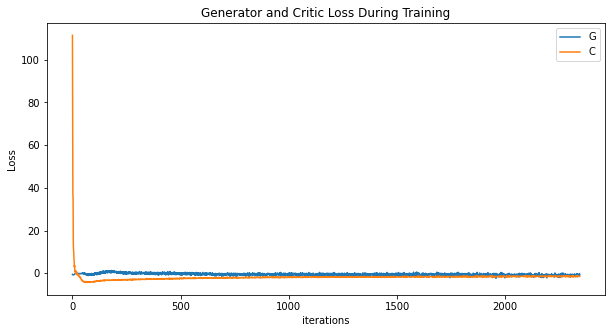

In [12]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Critic Loss During Training")
plt.plot(losses_generator, label="G")
plt.plot(losses_critic, label="C")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

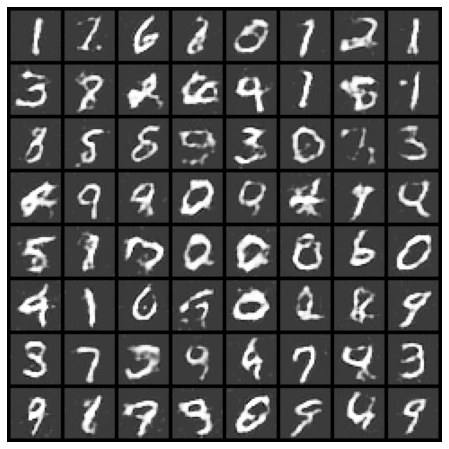

In [13]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())